In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [3]:
_4dm3_data_fp = 'dataset/4dm3.db'
_4dm4_data_fp = 'dataset/4dm4.db'
soft6_data_fp = 'dataset/soft6.db'
mwc21_data_fp = 'dataset/mwc2021.db'
mwc22_data_fp = 'dataset/mwc2022.db'

_4dm4_connection = sqlite3.connect(_4dm4_data_fp)
_4dm3_connection = sqlite3.connect(_4dm3_data_fp)
soft6_connection = sqlite3.connect(soft6_data_fp)
mwc21_connection = sqlite3.connect(mwc21_data_fp)
mwc22_connection = sqlite3.connect(mwc22_data_fp)

In [4]:
_4dm4_sql = """SELECT player_id, scores.player_name, round, beatmap_type, beatmap_tag, score, score_logit FROM scores JOIN player_data ON player_data.player_name = scores.player_name WHERE beatmap_type != \"SV\""""
_4dm3_sql = """SELECT player_id, scores.player_name, round, beatmap_type, beatmap_tag, score, score_logit FROM scores JOIN players ON players.player_name = scores.player_name WHERE beatmap_type != \"SV\""""

soft_sql = """SELECT player_id, players.name as player_name, scores.beatmap_id, mappools.round, mappools.beatmap_type, scores.score
FROM scores LEFT JOIN mappools ON (scores.beatmap_id = mappools.beatmap_id)
INNER JOIN players ON (scores.player_id = players.id)"""

mwc2022_query = """SELECT players.player_id, players.player_name, 
beatmaps.beatmap_id, beatmaps.beatmap_type, beatmaps.round,
scores.score 
FROM scores JOIN players ON scores.player_id = players.player_id
JOIN beatmaps ON scores.beatmap_id = beatmaps.beatmap_id
WHERE beatmaps.beatmap_type != \"SV\""""

mwc2021_query = mwc2022_query.replace("players", "player_data").replace("scores", "player_scores")

_4dm4_dataset = pd.read_sql(_4dm4_sql, _4dm4_connection)
_4dm3_dataset = pd.read_sql(_4dm3_sql, _4dm3_connection)
soft6_dataset = pd.read_sql(soft_sql, soft6_connection)
mwc2021_dataset = pd.read_sql(mwc2021_query, mwc21_connection)
mwc2022_dataset = pd.read_sql(mwc2022_query, mwc22_connection)

In [5]:
soft6_dataset = soft6_dataset.rename({'beatmap_id': 'beatmap_tag'}, axis=1)
mwc2021_dataset = mwc2021_dataset.rename({'beatmap_id': 'beatmap_tag'}, axis=1)
mwc2022_dataset = mwc2022_dataset.rename({'beatmap_id': 'beatmap_tag'}, axis=1)

In [6]:
def logit(x):
    return np.log(x / (1e6 - x))

soft6_dataset['score_logit'] = soft6_dataset['score'].apply(logit)
mwc2021_dataset['score_logit'] = mwc2021_dataset['score'].apply(logit)
mwc2022_dataset['score_logit'] = mwc2022_dataset['score'].apply(logit)


In [7]:
from utils.etimodel import GeneralizedETIModel

main_beatmap_category = ['RC', 'HB', 'LN']

_4dm3_model = GeneralizedETIModel(_4dm4_dataset, main_beatmap_category, l1_alpha=1, l2_alpha=0)
soft6_model = GeneralizedETIModel(_4dm4_dataset, main_beatmap_category, l1_alpha=0, l2_alpha=1)
mwc2021_model = GeneralizedETIModel(_4dm4_dataset, main_beatmap_category, l1_alpha=1, l2_alpha=0)
mwc2022_model = GeneralizedETIModel(_4dm4_dataset, main_beatmap_category, l1_alpha=0, l2_alpha=0.5)


In [8]:
_4dm3_model.fit_regression(_4dm3_dataset)
soft6_model.fit_regression(soft6_dataset)
mwc2021_model.fit_regression(mwc2021_dataset)
mwc2022_model.fit_regression(mwc2022_dataset)

In [9]:
_4dm3_etis = _4dm3_model.predict(_4dm3_dataset)
soft6_etis = soft6_model.predict(soft6_dataset)
mwc21_etis = mwc2021_model.predict(mwc2021_dataset)
mwc22_etis = mwc2022_model.predict(mwc2022_dataset)

In [10]:
_4dm4_etis = _4dm3_model._4dm_eti().mean(axis=1)
_4dm4_etis = pd.DataFrame(_4dm4_etis)

In [11]:
_4dm4_etis['source'] = '4dm4'
_4dm3_etis['source'] = '4dm3'
soft6_etis['source'] = 'soft6'
mwc21_etis['source'] = 'mwc21'
mwc22_etis['source'] = 'mwc22'

In [12]:
etis = pd.concat((soft6_etis, _4dm3_etis, _4dm4_etis, mwc21_etis, mwc22_etis)).reset_index().groupby('index').max()

In [13]:
_4dm4_and_global_etis = etis

In [14]:
mwc_top12_query = """SELECT player_id, player_name FROM players 
LEFT JOIN team_data ON team_data.country_code = players.country_code
WHERE team_data.last_round in ("Quarterfinals", "Semifinals", "Finals", "Grand Finals")"""

mwc22_top12_list = pd.read_sql(mwc_top12_query, mwc22_connection)
mwc21_top12_list = pd.read_sql(mwc_top12_query.replace("players", "player_data"), mwc21_connection)

In [15]:
mwc_top_list = np.union1d(mwc22_top12_list['player_name'].values.flatten(), mwc21_top12_list['player_name'].values.flatten())

In [16]:
def assign_skillban(x):
    if x['source'] in ['mwc21', 'mwc22']:
        if x['index'] in mwc_top_list:
            return 1
        return 0
    if x['source'] in ['4dm4', '4dm3']:
        return 0
    return 1

In [17]:
a = _4dm4_and_global_etis.reset_index().apply(assign_skillban, axis=1).values.flatten()

In [18]:
_4dm4_and_global_etis['skillban_prob'] = a

In [19]:
_4dm4_and_global_etis['skillban_prob']

index
- Abby -       0
- Kura -       1
- Pixie -      1
--Pavin--      1
-Aishiteru-    1
              ..
xxxxxx2800     1
yaya901609     0
yetii          0
yoppy-yugen    1
zipp           0
Name: skillban_prob, Length: 616, dtype: int64

In [20]:
weak_prob = 0.5 # 1 - np.sum(_4dm4_and_global_etis['skillban_prob']) / len(_4dm4_and_global_etis)
std = np.sqrt(weak_prob * (1 - weak_prob))
strong_prob = 0.9 # weak_prob + 0.5 * std

In [21]:
from sklearn.linear_model import LogisticRegression

x = _4dm4_and_global_etis[0].values.reshape(-1, 1)
y = _4dm4_and_global_etis['skillban_prob'].values

In [22]:
skillban_model = LogisticRegression(penalty='none')

skillban_model.fit(x, y)

LogisticRegression(penalty='none')

In [23]:
def predict(x: pd.DataFrame):
    return skillban_model.predict_proba(x[0].values.reshape(-1, 1))

In [24]:
_4kpp_estimate_dataset = pd.read_csv('dataset/4kpp_estimate.csv')
_4digit_players = _4kpp_estimate_dataset[_4kpp_estimate_dataset['rank'] >= 1000]

In [25]:
soft6_player_ids = pd.read_sql("""SELECT id, name FROM players""", soft6_connection)
mwc21_player_ids = pd.read_sql("""SELECT player_id as id, player_name as name FROM player_data""", mwc21_connection)
mwc22_player_ids = pd.read_sql("""SELECT player_id as id, player_name as name FROM players""", mwc22_connection)
soft6_player_ids.index = soft6_player_ids['id']
mwc21_player_ids.index = mwc21_player_ids['id']
mwc22_player_ids.index = mwc22_player_ids['id']

In [26]:
list_4d_soft6_players = np.intersect1d(_4digit_players['user_id'], soft6_player_ids['id'])
_4digit_in_soft = soft6_player_ids.loc[list_4d_soft6_players]['name'].values
list_4d_mwc21_players = np.intersect1d(_4digit_players['user_id'], mwc21_player_ids['id'])
_4digit_in_mwc21 = mwc21_player_ids.loc[list_4d_mwc21_players]['name'].values
list_4d_mwc22_players = np.intersect1d(_4digit_players['user_id'], mwc22_player_ids['id'])
_4digit_in_mwc22 = mwc22_player_ids.loc[list_4d_mwc22_players]['name'].values

In [27]:
soft6_etis_4digit = soft6_etis[soft6_etis.index.isin(_4digit_in_soft)]
mwc21_etis_4digit = mwc21_etis[mwc21_etis.index.isin(_4digit_in_mwc21)]
mwc22_etis_4digit = mwc22_etis[mwc22_etis.index.isin(_4digit_in_mwc22)]

In [28]:
etis_final = pd.concat((_4dm4_etis, _4dm3_etis, soft6_etis_4digit, mwc21_etis_4digit, mwc22_etis_4digit))

In [29]:
etis_final

,0,source
drag_,-1.991885,4dm4
JPBenedictGame,-1.800725,4dm4
iVALORUS,-2.036732,4dm4
BL5,-1.438920,4dm4
-Tebo-,0.060721,4dm4
...,...,...
yaya901609,1.001109,mwc22
[SPNG] Sim0,1.975096,mwc22
SitekX,1.523567,mwc22
NeonDrakon,1.340413,mwc22


In [30]:
model_prediction = predict(etis_final)

In [31]:
etis_final['model_prediction'] = model_prediction[:, -1]

In [32]:
etis_final = etis_final.sort_values(by='model_prediction', ascending=False)

In [33]:
def determine_skillbans(model_pred):
    if model_pred > strong_prob:
        return "Strong"
    if model_pred > weak_prob:
        return "Weak"
    return "Pass"

In [34]:
etis_final['skillban'] = etis_final['model_prediction'].apply(determine_skillbans)

In [35]:
etis_final

,0,source,model_prediction,skillban
cheewee10,16.833658,mwc21,0.999988,Strong
shokoha,13.858188,4dm4,0.999886,Strong
cheewee10,11.178717,mwc22,0.999139,Strong
[-Leon-],10.185749,4dm3,0.998181,Strong
nayuu,8.083927,mwc21,0.991194,Strong
...,...,...,...,...
Yosuf,-2.222836,4dm4,0.045440,Pass
NotXbxx,-2.232947,4dm4,0.045110,Pass
JostinC,-2.255380,4dm4,0.044388,Pass
Kaito-kun,-2.292689,4dm4,0.043210,Pass


In [36]:
etis_final.to_csv('etis_final.csv')

In [37]:
skillbanned_players = etis_final[etis_final['skillban'] != 'Pass'].index

In [38]:
etis_skillbans = etis_final[etis_final['skillban'] != 'Pass']

etis_skillbans

,0,source,model_prediction,skillban
cheewee10,16.833658,mwc21,0.999988,Strong
shokoha,13.858188,4dm4,0.999886,Strong
cheewee10,11.178717,mwc22,0.999139,Strong
[-Leon-],10.185749,4dm3,0.998181,Strong
nayuu,8.083927,mwc21,0.991194,Strong
...,...,...,...,...
shaafs,1.854854,4dm3,0.507136,Weak
Arccat,1.843202,4dm3,0.504940,Weak
milk369,1.839065,4dm4,0.504161,Weak
ag0,1.831010,mwc21,0.502643,Weak


In [39]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from utils.ranked_lof import elastic_euclidean

metric = elastic_euclidean(1, 0.5, 0.5)

def get_model():
    return Pipeline([('imputer', KNNImputer(n_neighbors=25)), ('scaler', MinMaxScaler()), ('lof', LocalOutlierFactor(n_neighbors=10,metric=metric))])

In [40]:
_4dm3_categorized_etis = _4dm3_model.transform_eti(_4dm3_dataset)
_4dm4_categorized_etis = _4dm3_model._4dm_eti()
soft6_categorized_etis = soft6_model.transform_eti(soft6_dataset)
mwc21_categorized_etis = mwc2021_model.transform_eti(mwc2021_dataset)
mwc22_categorized_etis = mwc2022_model.transform_eti(mwc2022_dataset)

In [41]:
_4dm3_categorized_etis

,RC,HB,LN
- Abby -,-1.688281,-0.828103,-1.065219
-Deepdive-,3.901256,1.788404,2.773753
-H i k a r i-,-1.225286,-0.977147,-1.318876
-Isla-,-1.981923,-1.522845,-1.962929
-Julio,-0.686512,-0.621060,-0.954183
...,...,...,...
v3yron03,-1.324189,-1.398286,-1.745400
walmart5193,-0.831080,-0.574687,-1.413917
xhsi,-1.853278,-1.436780,-1.617371
xxmaschxx,-0.938498,-1.124081,-1.151692


In [42]:
datasets = [_4dm3_categorized_etis, _4dm4_categorized_etis, soft6_categorized_etis, mwc21_categorized_etis, mwc22_categorized_etis]
sources = ['4dm3', '4dm4', 'soft6', 'mwc21', 'mwc22']

def merge_dataset(datasets, sources):
    indices = [list(ds.index) for ds in datasets]
    ind_ = []
    for idxs in indices:
        ind_.extend(idxs)
    new_dataset = pd.DataFrame(index=np.unique(ind_))
    for dataset, source in zip(datasets, sources):

        new_col_mapper = {col_name: source + "_" + col_name for col_name in dataset.columns}
        ds_rename = dataset.rename(new_col_mapper, axis=1)
        for col in ds_rename.columns:
            new_dataset[col] = ds_rename[col]
    return new_dataset

In [43]:
merged_dataset = merge_dataset(datasets, sources)

In [44]:
merged_dataset

,4dm3_RC,4dm3_HB,4dm3_LN,4dm4_RC,4dm4_HB,4dm4_LN,soft6_RC,soft6_HB,soft6_LN,mwc21_RC,mwc21_HB,mwc21_LN,mwc22_RC,mwc22_HB,mwc22_LN
- Abby -,-1.688281,-0.828103,-1.065219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
- Kura -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.651643,-0.508711,-1.129336,NaN,NaN,NaN
- Pixie -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.137920,-0.969032,-0.418202,-1.956322,-1.168929,-1.992281
--Pavin--,NaN,NaN,NaN,10.552292,5.994294,2.56129,NaN,NaN,NaN,NaN,NaN,NaN,0.026522,-0.710967,1.002948
-Aishiteru-,NaN,NaN,NaN,NaN,NaN,NaN,13.316789,5.236589,3.464350,6.954726,3.137075,4.607196,6.778221,1.598350,2.883705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xxxxxx2800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.578387,3.690497,4.952869,3.924275,1.892965,3.019405
yaya901609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.618199,-1.795112,-2.018706
yetii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.429572,-0.840498,-1.398862,NaN,NaN,NaN
yoppy-yugen,NaN,NaN,NaN,NaN,NaN,NaN,0.436619,-1.159670,-0.345227,NaN,NaN,NaN,0.341817,0.323224,1.133149


In [45]:
_4d_tournament_records = merged_dataset

In [46]:
_4d_tournament_records

,4dm3_RC,4dm3_HB,4dm3_LN,4dm4_RC,4dm4_HB,4dm4_LN,soft6_RC,soft6_HB,soft6_LN,mwc21_RC,mwc21_HB,mwc21_LN,mwc22_RC,mwc22_HB,mwc22_LN
- Abby -,-1.688281,-0.828103,-1.065219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
- Kura -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.651643,-0.508711,-1.129336,NaN,NaN,NaN
- Pixie -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.137920,-0.969032,-0.418202,-1.956322,-1.168929,-1.992281
--Pavin--,NaN,NaN,NaN,10.552292,5.994294,2.56129,NaN,NaN,NaN,NaN,NaN,NaN,0.026522,-0.710967,1.002948
-Aishiteru-,NaN,NaN,NaN,NaN,NaN,NaN,13.316789,5.236589,3.464350,6.954726,3.137075,4.607196,6.778221,1.598350,2.883705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xxxxxx2800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.578387,3.690497,4.952869,3.924275,1.892965,3.019405
yaya901609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.618199,-1.795112,-2.018706
yetii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.429572,-0.840498,-1.398862,NaN,NaN,NaN
yoppy-yugen,NaN,NaN,NaN,NaN,NaN,NaN,0.436619,-1.159670,-0.345227,NaN,NaN,NaN,0.341817,0.323224,1.133149


In [47]:
_4d_tournament_records = _4d_tournament_records[_4d_tournament_records.index.isin(skillbanned_players)]

In [48]:
rc_data = _4d_tournament_records[_4d_tournament_records.columns[_4d_tournament_records.columns.map(lambda x: 'RC' in x)]]
hb_data = _4d_tournament_records[_4d_tournament_records.columns[_4d_tournament_records.columns.map(lambda x: 'HB' in x)]]
ln_data = _4d_tournament_records[_4d_tournament_records.columns[_4d_tournament_records.columns.map(lambda x: 'LN' in x)]]
_4dm4_data = _4d_tournament_records[_4d_tournament_records.columns[_4d_tournament_records.columns.map(lambda x: '4dm4' in x)]]
_4dm3_data = _4d_tournament_records[_4d_tournament_records.columns[_4d_tournament_records.columns.map(lambda x: '4dm3' in x)]]
mwc21_data = _4d_tournament_records[_4d_tournament_records.columns[_4d_tournament_records.columns.map(lambda x: 'mwc21' in x)]]
mwc22_data = _4d_tournament_records[_4d_tournament_records.columns[_4d_tournament_records.columns.map(lambda x: 'mwc22' in x)]]
soft6_data = _4d_tournament_records[_4d_tournament_records.columns[_4d_tournament_records.columns.map(lambda x: 'soft6' in x)]]

In [49]:
rc_model = get_model()
hb_model = get_model()
ln_model = get_model()
_4dm4_model = get_model()
_4dm3_model = get_model()
mwc21_model = get_model()
mwc22_model = get_model()
soft6_model = get_model()

In [50]:
mwc21_data

,mwc21_RC,mwc21_HB,mwc21_LN
- Kura -,-1.651643,-0.508711,-1.129336
--Pavin--,NaN,NaN,NaN
-Deepdive-,NaN,NaN,NaN
2fast,-1.022725,-0.045678,0.124377
2fast4you98,NaN,NaN,NaN
...,...,...,...
samuelhklumpers,NaN,NaN,NaN
shaafs,-2.714372,-1.230501,-1.460031
shokoha,-2.536157,-0.560374,0.798377
stupud man,1.213749,1.863791,0.714469


In [51]:
rc_model.fit(rc_data)
hb_model.fit(hb_data)
ln_model.fit(ln_data)

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=25)),
                ('scaler', MinMaxScaler()),
                ('lof',
                 LocalOutlierFactor(metric=<function elastic_euclidean.<locals>._euclidean at 0x0000012E3F57ED40>,
                                    n_neighbors=10))])

In [52]:
_4dm4_model.fit(_4dm4_data)
_4dm3_model.fit(_4dm3_data)
mwc21_model.fit(mwc21_data)
mwc22_model.fit(mwc22_data)
soft6_model.fit(soft6_data)

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=25)),
                ('scaler', MinMaxScaler()),
                ('lof',
                 LocalOutlierFactor(metric=<function elastic_euclidean.<locals>._euclidean at 0x0000012E3F57ED40>,
                                    n_neighbors=10))])

In [53]:
lof_result = pd.DataFrame(index=_4d_tournament_records.index)

lof_result['RC'] = rc_model['lof'].negative_outlier_factor_ * (-1)
lof_result['HB'] = hb_model['lof'].negative_outlier_factor_ * (-1)
lof_result['LN'] = ln_model['lof'].negative_outlier_factor_ * (-1)

lof_result['4dm4'] = _4dm4_model['lof'].negative_outlier_factor_ * (-1)
lof_result['4dm3'] = _4dm3_model['lof'].negative_outlier_factor_ * (-1)
lof_result['mwc21'] = mwc21_model['lof'].negative_outlier_factor_ * (-1)
lof_result['mwc22'] = mwc22_model['lof'].negative_outlier_factor_ * (-1)
lof_result['soft6'] = soft6_model['lof'].negative_outlier_factor_ * (-1)

In [54]:
lof_result

,RC,HB,LN,4dm4,4dm3,mwc21,mwc22,soft6
- Kura -,1.002987,0.994889,0.990014,1.000000,1.000000,0.993996,1.000000,1.000000
--Pavin--,1.347386,1.064401,1.164971,1.291700,1.000000,1.000000,2.252683,1.000000
-Deepdive-,0.998884,0.985436,0.996939,1.000000,0.998584,1.000000,1.000000,1.000000
2fast,1.136243,1.035939,1.005594,1.000000,1.000000,1.397902,0.904251,1.412928
2fast4you98,1.157223,1.337457,1.106980,1.000000,1.292096,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...
samuelhklumpers,0.988872,0.990409,0.984144,0.986885,1.000344,1.000000,1.004842,1.000000
shaafs,0.963834,0.955916,0.976692,0.921054,0.980494,0.914423,1.000000,1.000000
shokoha,1.478903,1.808254,1.844801,2.218978,1.318453,1.187551,1.000000,1.702827
stupud man,1.210263,1.247088,1.049988,1.000000,1.000000,2.087258,1.000000,1.000000


In [55]:
lof_result.to_csv('skillbans_selections.csv')

In [56]:
x = np.log(lof_result[['RC', 'HB', 'LN']])
nanx = x.copy()
nanx[nanx == 0] = np.nan
lof_result['metric'] = np.nanmean(((nanx - nanx.min()) / (nanx.max() - nanx.min())) ** 2, axis=1)

In [57]:
idk = (nanx - nanx.min()) / (nanx.max() - nanx.min())

idk.loc['ZayyKen']

RC    0.271968
HB    0.073212
LN    0.196056
Name: ZayyKen, dtype: float64

In [58]:
lof_result.sort_values(by='metric', ascending=False).head(20)

,RC,HB,LN,4dm4,4dm3,mwc21,mwc22,soft6,metric
cheewee10,1.713723,2.673490,2.249092,1.000000,1.000000,4.859317,3.811931,1.000000,1.000000
Stability,1.438605,1.453618,2.199074,1.000000,1.000000,1.245175,1.307501,2.707694,0.538824
shokoha,1.478903,1.808254,1.844801,2.218978,1.318453,1.187551,1.000000,1.702827,0.516472
DemiFiendSMT,1.100808,1.930849,2.036265,1.000000,1.000000,1.000000,2.715607,2.615659,0.439969
[-Leon-],1.253185,1.497566,1.561767,1.000000,1.646701,1.000000,1.000000,1.000000,0.251470
_lyko,1.513030,0.994330,0.984734,1.000000,1.000000,1.382067,2.033722,1.000000,0.209058
--Pavin--,1.347386,1.064401,1.164971,1.291700,1.000000,1.000000,2.252683,1.000000,0.141067
henryalexbr,1.360932,1.104382,1.041299,1.317905,1.000000,1.000000,1.481580,1.000000,0.135697
Yuragi,1.345633,1.120181,1.073273,1.000000,1.432978,1.000000,1.000000,1.000000,0.132525
MIkuaimbot,1.085701,1.077625,1.500382,1.000000,1.000000,1.482359,2.510531,1.033890,0.117626


(array([72.,  6.,  2.,  0.,  1.,  2.,  0.,  0.,  0.,  1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

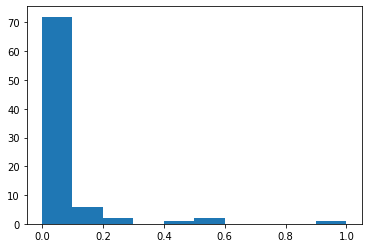

In [59]:
plt.hist(lof_result['metric'])

In [60]:
lof_result[lof_result['metric'] > lof_result['metric'].mean()].sort_values(by='metric', ascending=False).head(50)

,RC,HB,LN,4dm4,4dm3,mwc21,mwc22,soft6,metric
cheewee10,1.713723,2.673490,2.249092,1.000000,1.000000,4.859317,3.811931,1.000000,1.000000
Stability,1.438605,1.453618,2.199074,1.000000,1.000000,1.245175,1.307501,2.707694,0.538824
shokoha,1.478903,1.808254,1.844801,2.218978,1.318453,1.187551,1.000000,1.702827,0.516472
DemiFiendSMT,1.100808,1.930849,2.036265,1.000000,1.000000,1.000000,2.715607,2.615659,0.439969
[-Leon-],1.253185,1.497566,1.561767,1.000000,1.646701,1.000000,1.000000,1.000000,0.251470
_lyko,1.513030,0.994330,0.984734,1.000000,1.000000,1.382067,2.033722,1.000000,0.209058
--Pavin--,1.347386,1.064401,1.164971,1.291700,1.000000,1.000000,2.252683,1.000000,0.141067
henryalexbr,1.360932,1.104382,1.041299,1.317905,1.000000,1.000000,1.481580,1.000000,0.135697
Yuragi,1.345633,1.120181,1.073273,1.000000,1.432978,1.000000,1.000000,1.000000,0.132525
MIkuaimbot,1.085701,1.077625,1.500382,1.000000,1.000000,1.482359,2.510531,1.033890,0.117626


In [61]:
lof_result['skillbans'] = lof_result['metric'].apply(lambda x: "Strong" if x > lof_result['metric'].mean() else "Pass")

In [62]:
lof_result.to_csv("etis_final_final.csv")

## Highlighted Scores

In [63]:
from utils.highlights import get_highlighted_scores

n_highlighted_scores = 5
highlighted_scores = pd.DataFrame()

In [64]:
_4dm3_mappool = pd.read_sql("SELECT * FROM beatmaps", _4dm3_connection)
_4dm4_mappool = pd.read_sql("SELECT * FROM beatmaps", _4dm4_connection)
soft6_mappool = pd.read_sql("SELECT * FROM mappools", soft6_connection)
mwc21_mappool = pd.read_sql("SELECT * FROM beatmaps", mwc21_connection)
mwc22_mappool = pd.read_sql("SELECT * FROM beatmaps", mwc22_connection)

In [65]:
def retrieve_4dm3_beatmap_info(beatmap):
    stage, bmtype, bmtag = beatmap.split("_")
    beatmap_info = _4dm3_mappool[(_4dm3_mappool['round'] == stage) & (_4dm3_mappool['beatmap_type'] == bmtype) & (_4dm3_mappool['beatmap_tag'] == bmtag)]
    try:
        return f"{beatmap_info['Artist'].values.flatten()[0]} - {beatmap_info['Title'].values.flatten()[0]} [{beatmap_info['Difficulty'].values.flatten()[0]}]", beatmap_info['Beatmap ID'].values.flatten()[0]
    except IndexError:
        return "beatmap not found"

def retrieve_4dm4_beatmap_info(beatmap):
    stage, bmtype, bmtag = beatmap.split("_")
    beatmap_info = _4dm4_mappool[(_4dm4_mappool['round'] == stage) & (_4dm4_mappool['beatmap_type'] == bmtype) & (_4dm4_mappool['beatmap_tag'] == int(bmtag))]
    return beatmap_info['metadata'].values.flatten()[0], beatmap_info['beatmap_id'].values.flatten()[0]

def retrieve_soft6_beatmap_info(beatmap):
    stage, bm_type, beatmap_id = beatmap.split("_")
    beatmap_info = soft6_mappool[soft6_mappool['beatmap_id'] == beatmap_id]
    try:
        return beatmap_info['beatmap_metadata'].values.flatten()[0], beatmap_info['beatmap_id'].values.flatten()[0]
    except IndexError:
        return "beatmap not found"

def retrieve_mwc2021_beatmap_info(beatmap):
    stage, bm_type, beatmap_id = beatmap.split("_")
    beatmap_info = mwc21_mappool[mwc21_mappool['beatmap_id'] == int(beatmap_id)]
    try:
        return beatmap_info['beatmap_metadata'].values.flatten()[0], beatmap_info['beatmap_id'].values.flatten()[0]
    except IndexError:
        return "beatmap not found"

def retrieve_mwc2022_beatmap_info(beatmap):
    stage, bm_type, beatmap_id = beatmap.split("_")
    beatmap_info = mwc22_mappool[mwc22_mappool['beatmap_id'] == int(beatmap_id)]
    try:
        return beatmap_info['beatmap_metadata'].values.flatten()[0], beatmap_info['beatmap_id'].values.flatten()[0]
    except IndexError:
        return "beatmap not found"

In [66]:
source_dataset = {
    '4dm4': (_4dm4_dataset, retrieve_4dm4_beatmap_info),
    '4dm3': (_4dm3_dataset, retrieve_4dm3_beatmap_info),
    'soft6': (soft6_dataset, retrieve_soft6_beatmap_info),
    'mwc21': (mwc2021_dataset, retrieve_mwc2021_beatmap_info),
    'mwc22': (mwc2022_dataset, retrieve_mwc2022_beatmap_info)
}

In [67]:
for tournament_acronym, (tournament_dataset, beatmap_search_func) in source_dataset.items():
    print(tournament_acronym)
    highlighted_score = get_highlighted_scores(skillbanned_players, tournament_dataset)
    highlighted_score['source'] = tournament_acronym
    highlighted_score['beatmap_metadata'] = highlighted_score['beatmap'].apply(beatmap_search_func)
    highlighted_score['beatmap_category'] = highlighted_score['beatmap']
    highlighted_score = highlighted_score.drop(['beatmap'], axis=1)
    highlighted_scores = pd.concat((highlighted_scores, highlighted_score))

4dm4
4dm3
soft6
mwc21
mwc22


In [68]:
highlighted_scores['beatmap_id'] = highlighted_scores['beatmap_metadata'].apply(lambda x: x[1])
highlighted_scores['beatmap_metadata'] = highlighted_scores['beatmap_metadata'].apply(lambda x: x[0])

In [69]:
highlighted_scores

,player_name,level_1,player_id,score,standardized,source,beatmap_metadata,beatmap_category,beatmap_id
0,--Pavin--,0,12046267,992893,1.770349,4dm4,Fleshgod Apocalypse - Fury (DannyPX) [Conflagr...,Q_RC_2,3399979
1,--Pavin--,1,12046267,986575,1.325363,4dm4,beatmap is deleted,F_HB_3,3459250
2,--Pavin--,2,12046267,991326,1.259055,4dm4,Blitz Lunar - The Labyrinth of Skadi (hi19hi19...,SF_RC_4,3445070
3,--Pavin--,3,12046267,994157,1.239695,4dm4,Ryuno - love hurts. (lonely dance mix) (Mipha-...,QF_RC_2,3413561
4,--Pavin--,4,12046267,989757,1.114220,4dm4,YONEDA - KAERU (CrewK) [Frog Regrets],GF_RC_1,3463278
...,...,...,...,...,...,...,...,...,...
145,samuelhklumpers,3,10945523,981220,-0.633509,mwc22,Toromaru - Formless Canvas (-mint-) [Abstract],Round of 16_LN_3682794,3682794
142,samuelhklumpers,0,10945523,989452,-0.248163,mwc22,Se-U-Ra - QSHELL -Kyoshoku no Shell- (guden) [...,Round of 32_HB_3739900,3739900
143,samuelhklumpers,1,10945523,987502,-0.342862,mwc22,Galderia - Almagest (stupud man) [Constellar],Round of 32_LN_3555653,3555653
144,samuelhklumpers,2,10945523,984658,-0.467339,mwc22,xi - Double Helix (Mipha-) [bmah's Challenge 1...,Round of 16_RC_3753063,3753063


In [70]:
highlighted_scores.to_csv("highlight_generalized.csv")

In [71]:
samples = etis_final.index.unique()

In [72]:
n_highlighted_scores = 5
samples_highlighted_scores = pd.DataFrame()

for tournament_acronym, (tournament_dataset, beatmap_search_func) in source_dataset.items():
    highlighted_score = get_highlighted_scores(samples, tournament_dataset)
    highlighted_score['source'] = tournament_acronym
    highlighted_score['beatmap_metadata'] = highlighted_score['beatmap'].apply(beatmap_search_func)
    highlighted_score['beatmap_category'] = highlighted_score['beatmap']
    highlighted_score = highlighted_score.drop(['beatmap'], axis=1)
    samples_highlighted_scores = pd.concat((samples_highlighted_scores, highlighted_score))

In [73]:
samples_highlighted_scores['beatmap_id'] = samples_highlighted_scores['beatmap_metadata'].apply(lambda x: x[1])
samples_highlighted_scores['beatmap_metadata'] = samples_highlighted_scores['beatmap_metadata'].apply(lambda x: x[0])

In [74]:
samples_highlighted_scores.to_csv("sample_highlight.csv")